In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

%cd ..
project_root = Path.cwd()
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from musicagent.config import DataConfig
from musicagent.data import OfflineDataset, make_offline_collate_fn
from musicagent.eval.metrics import (
    chord_length_entropy,
    chord_lengths,
    note_in_chord_ratio,
    onset_interval_emd,
    onset_intervals,
)
from musicagent.utils import compute_test_set_histograms

d_cfg = DataConfig()
if not d_cfg.data_processed.is_absolute():
    d_cfg.data_processed = project_root / d_cfg.data_processed

test_ds = OfflineDataset(d_cfg, split="test")
collate_fn = make_offline_collate_fn(pad_id=d_cfg.pad_id)

test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Use the unified vocabulary exposed by the dataset for decoding.
id_to_token = test_ds.unified_id_to_token


def decode_tokens(ids):
    return [id_to_token.get(int(i), "<unk>") for i in ids]

/Users/drewtaylor/data


/Users/drewtaylor/data/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reference metrics

all_nic_ref = []
all_ref_intervals = []
all_ref_lengths = []

for src, tgt in test_loader:
    for i in range(src.size(0)):
        mel_ids = src[i].cpu().tolist()
        ref_ids = tgt[i].cpu().tolist()

        mel_tokens = decode_tokens(mel_ids)
        ref_tokens = decode_tokens(ref_ids)

        # NiC
        all_nic_ref.append(note_in_chord_ratio(mel_tokens, ref_tokens))

        all_ref_intervals.extend(onset_intervals(mel_tokens, ref_tokens))
        all_ref_lengths.extend(chord_lengths(ref_tokens))

avg_nic_ref = sum(all_nic_ref) / len(all_nic_ref) if all_nic_ref else 0.0
ref_emd_self = onset_interval_emd(all_ref_intervals, all_ref_intervals)
ref_entropy = chord_length_entropy(all_ref_lengths)

print(f"Reference NiC:            {avg_nic_ref * 100:.2f}%")
print("Reference Onset Interval EMD:", ref_emd_self)
print("Reference Chord Length Entropy:", ref_entropy)

Reference NiC:            65.31%
Reference Onset Interval EMD: 0.0
Reference Chord Length Entropy: 2.2640696348687377


Test-set chord length entropy (nats): 2.2640696348687377


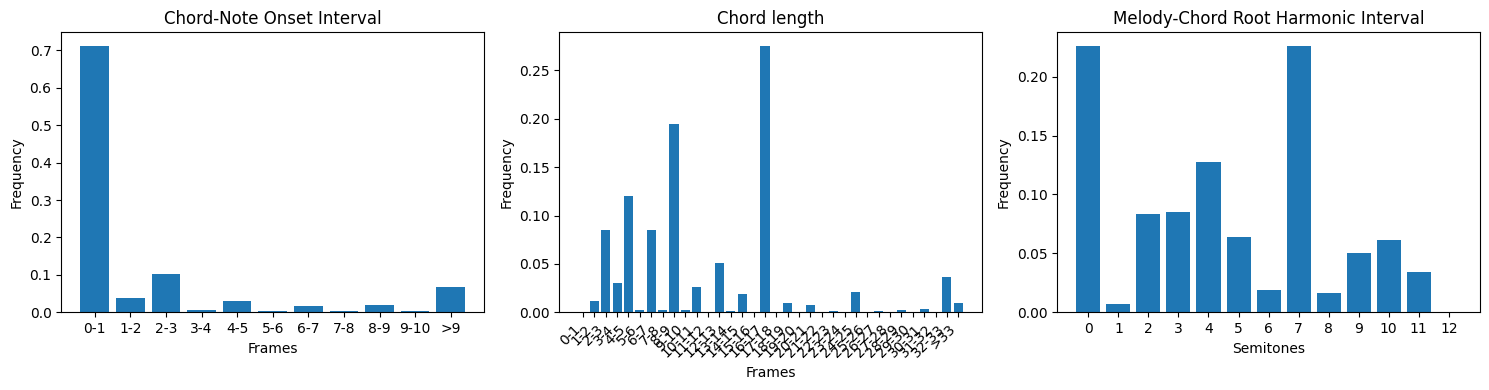

In [5]:
test_hist = compute_test_set_histograms(test_loader, id_to_token)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Chord–note onset interval
x_on = np.arange(test_hist.onset_hist.shape[0])
axes[0].bar(x_on, test_hist.onset_hist)
axes[0].set_title("Chord-Note Onset Interval")
axes[0].set_xlabel("Frames")
axes[0].set_ylabel("Frequency")
axes[0].set_xticks(x_on)
onset_labels = [f"{i}-{i + 1}" for i in range(len(x_on) - 1)] + [">9"]
axes[0].set_xticklabels(onset_labels)

# Chord length
x_len = np.arange(test_hist.chord_length_hist.shape[0])
axes[1].bar(x_len, test_hist.chord_length_hist)
axes[1].set_title("Chord length")
axes[1].set_xlabel("Frames")
axes[1].set_ylabel("Frequency")
length_labels = [f"{i}-{i + 1}" for i in range(len(x_len) - 1)] + [">33"]
axes[1].set_xticks(x_len)
axes[1].set_xticklabels(length_labels, rotation=45, ha="right")

# Melody–chord root harmonic interval
x_harm = np.arange(test_hist.harmonic_interval_hist.shape[0])
axes[2].bar(x_harm, test_hist.harmonic_interval_hist)
axes[2].set_title("Melody-Chord Root Harmonic Interval")
axes[2].set_xlabel("Semitones")
axes[2].set_ylabel("Frequency")
axes[2].set_xticks(x_harm)
axes[2].set_xticklabels([str(i) for i in range(len(x_harm))])

fig.tight_layout()

print("Test-set chord length entropy (nats):", test_hist.chord_length_entropy)